<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/pyro_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Pyro](https://pyro.ai/) is a probabilistic programming system built on top of PyTorch. It supports posterior inference based on MCMC and stochastic variational inference; discrete latent variables can be marginalized out exactly using dynamic programmming.

In [1]:
!pip install pyro-ppl 

     |████████████████████████████████| 634kB 5.4MB/s 


In [47]:


import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import MCMC, NUTS, Predictive, HMC
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import EmpiricalMarginal

from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import scalar_like
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning

pyro.set_rng_seed(101)


# Example: inferring mean of 1d Gaussian .

We use the simple example from the [Pyro intro](https://pyro.ai/examples/intro_part_ii.html#A-Simple-Example). The goal is to infer the weight $\theta$ of an object, given noisy measurements $y$. We assume the following model:
$$
\begin{align}
\theta &\sim N(\mu=8.5, \tau^2=1.0)\\ 
y \sim &N(\theta, \sigma^2=0.75^2)
\end{align}
$$

Where $\mu=8.5$ is the initial guess. 



## Exact inference

By Bayes rule for Gaussians, we know that the exact posterior,
given a single observation $y=9.5$, is given by


$$
\begin{align}
\theta|y &\sim N(m, s^s) \\
m &=\frac{\sigma^2 \mu + \tau^2 y}{\sigma^2 + \tau^2} 
  = \frac{0.75^2 \times 8.5 + 1 \times 9.5}{0.75^2 + 1^2}
  = 9.14 \\
s^2 &= \frac{\sigma^2 \tau^2}{\sigma^2  + \tau^2} 
= \frac{0.75^2 \times 1^2}{0.75^2 + 1^2}= 0.6^2
\end{align}
$$

In [8]:
mu = 8.5; tau = 1.0; sigma = 0.75; 
hparams = (mu, tau, sigma)

y = 9.5
m = (sigma**2 * mu + tau**2 * y)/(sigma**2 + tau**2) # posterior mean
s2 = (sigma**2 * tau**2)/(sigma**2 + tau**2) # posterior variance
s = np.sqrt(s2)
print(m)
print(s)

9.14
0.6


## Pyro model

In [56]:

def model(hparams, data=None):
    prior_mean, prior_sd, obs_sd = hparams
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    y = pyro.sample("y", dist.Normal(theta, obs_sd), obs=data)
    return y



## Ancestral sampling

In [68]:
def model2(hparams, data=None):
    prior_mean, prior_sd, obs_sd = hparams
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    y = pyro.sample("y", dist.Normal(theta, obs_sd), obs=data)
    return theta, y

for i in range(5):
  theta, y = model2(hparams)
  print([theta, y])


[tensor(9.1529), tensor(8.7116)]
[tensor(8.7306), tensor(9.3978)]
[tensor(9.0740), tensor(9.4240)]
[tensor(7.3040), tensor(7.8569)]
[tensor(7.8939), tensor(8.0257)]


## MCMC

See [the documentation](http://docs.pyro.ai/en/0.2.1-release/mcmc.html)

In [52]:
true_coefs = torch.tensor([1., 2., 3.])
data = torch.randn(2000, 3)
dim = 3
labels = dist.Bernoulli(logits=(true_coefs * data).sum(-1)).sample()

def model(data):
  coefs_mean = torch.zeros(dim)
  coefs = pyro.sample('beta', dist.Normal(coefs_mean, torch.ones(3)))
  y = pyro.sample('y', dist.Bernoulli(logits=(coefs * data).sum(-1)), obs=labels)
  return y

hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc_run = MCMC(hmc_kernel, num_samples=500, warmup_steps=100).run(data)
posterior = EmpiricalMarginal(mcmc_run, 'beta')
posterior.mean  

Sample: 100%|██████████| 600/600 [00:01, 355.77it/s, step size=8.68e-01, acc. prob=0.857]


AssertionError: ignored

In [ ]:
samples  = mcmc.get_samples()
print(samples)

In [ ]:
#https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html
guess_prior = 10.
hmc_kernel = HMC(conditioned_scale, step_size=0.9, num_steps=4)
posterior = MCMC(hmc_kernel, 
                 num_samples=1000, 
                 warmup_steps=50).run(guess_prior)
                 
print(type(posterior))

## Stochastic Variational Inference

See [the documentation](http://docs.pyro.ai/en/0.2.1-release/inference_algos.html)




For the guide (approximate posterior), we use a [pytorch.distributions.normal](https://pytorch.org/docs/master/distributions.html#torch.distributions.normal.Normal).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


[9.205821990966797, 0.6176195740699768]


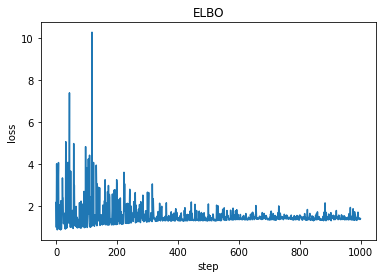

In [60]:
# the guide must have the same signature as the model
def guide(hparams, data):
  y = data
  prior_mean, prior_sd, obs_sd = hparams
  m = pyro.param("m", torch.tensor(y)) # location
  s = pyro.param("s", torch.tensor(prior_sd), constraint=constraints.positive) # scale
  return pyro.sample("theta", dist.Normal(m, s))


# initialize variational parameters
pyro.clear_param_store()

# set up the optimizer
#optimizer = pyro.optim.Adam({"lr": 0.001, "betas": (0.90, 0.999)})
optimizer = pyro.optim.SGD({"lr": 0.001, "momentum":0.1})

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
# do gradient steps
obs = torch.tensor(y)
loss_history, m_history, s_history  = [], [], []
for t in range(num_steps):
    loss_history.append(svi.step(hparams, obs))
    m_history.append(pyro.param("m").item())
    s_history.append(pyro.param("s").item())

plt.plot(loss_history)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

post_mean = pyro.param("m").item()
post_std = pyro.param("s").item()
print([post_mean, post_std])
